In [ ]:
!pip install transformers datasets seqeval torch accelerate peft matplotlib -q

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
    TrainerCallback
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
import torch

In [ ]:
print("✓ All libraries imported successfully!\n")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

✓ All libraries imported successfully!

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


In [ ]:
print("\n" + "="*80)
print("LOADING FEW-NERD DATASET (FULL)")
print("="*80)
# Load the supervised setting with fine-grained entity types
dataset = load_dataset("DFKI-SLT/few-nerd", "supervised")



LOADING FEW-NERD DATASET (FULL)


README.md: 0.00B [00:00, ?B/s]

supervised/train-00000-of-00001.parquet:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

supervised/validation-00000-of-00001.par(…):   0%|          | 0.00/2.42M [00:00<?, ?B/s]

supervised/test-00000-of-00001.parquet:   0%|          | 0.00/4.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/131767 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/18824 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/37648 [00:00<?, ? examples/s]

In [ ]:
print(f"\nDataset splits:")
print(f"  Train:      {len(dataset['train']):,} sentences")
print(f"  Validation: {len(dataset['validation']):,} sentences")
print(f"  Test:       {len(dataset['test']):,} sentences")
print(f"  Total:      {sum(len(dataset[split]) for split in dataset.keys()):,} sentences")


Dataset splits:
  Train:      131,767 sentences
  Validation: 18,824 sentences
  Test:       37,648 sentences
  Total:      188,239 sentences


In [ ]:
# We'll use a larger subset since training is fast with LoRA
print("\n" + "-"*80)
print("SAMPLING STRATEGY FOR LORA")
print("-"*80)

def sample_dataset(dataset, n_samples, seed=42):
    """Sample n_samples from dataset with fixed seed for reproducibility"""
    if n_samples >= len(dataset):
        return dataset
    indices = np.random.RandomState(seed).choice(
        len(dataset), size=n_samples, replace=False
    )
    return dataset.select(indices)


--------------------------------------------------------------------------------
SAMPLING STRATEGY FOR LORA
--------------------------------------------------------------------------------


In [ ]:
# Configuration: Since your 20K took only 5 min, let's use much more!
# LoRA is efficient, so we can handle larger datasets
TRAIN_SAMPLES = 100000   # ~76% of full training data
VAL_SAMPLES = 15000      # ~80% of validation data
RANDOM_SEED = 42

In [ ]:
dataset['train'] = sample_dataset(dataset['train'], TRAIN_SAMPLES, RANDOM_SEED)
dataset['validation'] = sample_dataset(dataset['validation'], VAL_SAMPLES, RANDOM_SEED)

In [ ]:
print(f"\n✓ Dataset configuration (Larger for LoRA efficiency):")
print(f"  Train:      {len(dataset['train']):,} sentences ({100*len(dataset['train'])/131767:.1f}% of original)")
print(f"  Validation: {len(dataset['validation']):,} sentences ({100*len(dataset['validation'])/18824:.1f}% of original)")
print(f"  Test:       {len(dataset['test']):,} sentences (100% - full test set)")
print(f"  Total:      {len(dataset['train']) + len(dataset['validation']):,} training samples")
print(f"\n  Expected training time: ~20-30 minutes (with LoRA on GPU)")



✓ Dataset configuration (Larger for LoRA efficiency):
  Train:      100,000 sentences (75.9% of original)
  Validation: 15,000 sentences (79.7% of original)
  Test:       37,648 sentences (100% - full test set)
  Total:      115,000 training samples

  Expected training time: ~20-30 minutes (with LoRA on GPU)


In [ ]:
# Examine dataset structure
print(f"\n✓ Example from training set:")
example = dataset['train'][0]
print(f"  Tokens: {example['tokens'][:15]}...")
print(f"  NER Tags: {example['fine_ner_tags'][:15]}...")



✓ Example from training set:
  Tokens: ['The', 'Denver', 'Public', 'Library', 'responded', 'by', 'building', 'a', 'new', 'Cosmopolitan', 'Branch', 'Library', 'in', 'Five', 'Points']...
  NER Tags: [0, 10, 10, 10, 0, 0, 0, 0, 0, 10, 10, 10, 0, 25, 25]...


In [ ]:
# ============================================================================
# SETUP MODEL AND TOKENIZER
# ============================================================================

print("\n" + "="*80)
print("LOADING MODEL AND TOKENIZER")
print("="*80)

MODEL_NAME = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, add_prefix_space=True)



LOADING MODEL AND TOKENIZER


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# Get fine-grained label list
label_list = dataset['train'].features['fine_ner_tags'].feature.names
num_labels = len(label_list)

In [ ]:
print(f"\n✓ Model: {MODEL_NAME}")
print(f"✓ Total entity types: {num_labels}")
print(f"\nEntity type categories:")
print("  • Person (actor, artist, athlete, director, politician, etc.)")
print("  • Location (GPE, body of water, island, mountain, road, etc.)")
print("  • Organization (company, education, government, media, etc.)")
print("  • Building (airport, hospital, hotel, library, restaurant, etc.)")
print("  • Art (broadcast, film, music, painting, written work, etc.)")
print("  • Product (airplane, car, food, game, ship, software, weapon, etc.)")
print("  • Event (attack/battle, disaster, election, protest, sports, etc.)")
print("  • Other (astronomy, biology, chemistry, currency, disease, law, etc.)")


✓ Model: roberta-base
✓ Total entity types: 67

Entity type categories:
  • Person (actor, artist, athlete, director, politician, etc.)
  • Location (GPE, body of water, island, mountain, road, etc.)
  • Organization (company, education, government, media, etc.)
  • Building (airport, hospital, hotel, library, restaurant, etc.)
  • Art (broadcast, film, music, painting, written work, etc.)
  • Product (airplane, car, food, game, ship, software, weapon, etc.)
  • Event (attack/battle, disaster, election, protest, sports, etc.)
  • Other (astronomy, biology, chemistry, currency, disease, law, etc.)


In [ ]:
# Create label mappings
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}


In [ ]:
# Load base model
base_model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

print(f"\n✓ Base model loaded with {num_labels} entity types")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✓ Base model loaded with 67 entity types


In [ ]:
print("\n" + "="*80)
print("CONFIGURING LORA (PEFT)")
print("="*80)

# LoRA configuration for RoBERTa
lora_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS,  # Token classification task
    r=16,                          # Rank of the low-rank matrices
    lora_alpha=32,                 # Scaling parameter (typically 2*r)
    lora_dropout=0.1,              # Dropout probability
    target_modules=["query", "value"],  # Apply LoRA to attention Q and V
    bias="none",                   # Don't train bias parameters
    inference_mode=False           # Training mode
)


CONFIGURING LORA (PEFT)


In [ ]:
print("LoRA Configuration:")
print(f"  Rank (r): {lora_config.r}")
print(f"  Alpha: {lora_config.lora_alpha}")
print(f"  Dropout: {lora_config.lora_dropout}")
print(f"  Target modules: {lora_config.target_modules}")
print(f"  Task type: {lora_config.task_type}")

LoRA Configuration:
  Rank (r): 16
  Alpha: 32
  Dropout: 0.1
  Target modules: {'query', 'value'}
  Task type: TaskType.TOKEN_CLS


In [ ]:
# Apply LoRA to the model
model = get_peft_model(base_model, lora_config)

In [ ]:
# Print model parameters
print("\n" + "="*80)
print("MODEL PARAMETER ANALYSIS")
print("="*80)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
trainable_percentage = 100 * trainable_params / total_params

print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters (LoRA): {trainable_params:,} ({trainable_percentage:.2f}%)")
print(f"Frozen Parameters: {total_params - trainable_params:,} ({100-trainable_percentage:.2f}%)")
print(f"\nParameter Efficiency: {total_params / trainable_params:.1f}x fewer trainable params")
print(f"Memory Savings: ~{(1 - trainable_percentage/100) * 100:.1f}% reduction in trainable memory")

model.print_trainable_parameters()



MODEL PARAMETER ANALYSIS

Total Parameters: 124,747,910
Trainable Parameters (LoRA): 641,347 (0.51%)
Frozen Parameters: 124,106,563 (99.49%)

Parameter Efficiency: 194.5x fewer trainable params
Memory Savings: ~99.5% reduction in trainable memory
trainable params: 641,347 || all params: 124,747,910 || trainable%: 0.5141


In [ ]:
# ============================================================================
# TOKENIZATION AND LABEL ALIGNMENT
# ============================================================================

print("\n" + "="*80)
print("TOKENIZING DATASETS")
print("="*80)

def tokenize_and_align_labels(examples):
    """
    Tokenize texts and align NER labels with subword tokens.
    Few-NERD uses IO tagging, so we handle entity boundaries properly.
    """
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding=False,
        max_length=512
    )

    labels = []
    for i, label in enumerate(examples["fine_ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None

        for word_idx in word_ids:
            if word_idx is None:
                # Special tokens get -100 (ignored in loss)
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # First subword of a word gets the label
                label_ids.append(label[word_idx])
            else:
                # Other subwords get -100 (ignored)
                label_ids.append(-100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


TOKENIZING DATASETS


In [ ]:
# Tokenize all splits
tokenized_train = dataset['train'].map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset['train'].column_names,
    desc="Tokenizing train"
)

Tokenizing train:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [ ]:
tokenized_val = dataset['validation'].map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset['validation'].column_names,
    desc="Tokenizing validation"
)

Tokenizing validation:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [ ]:
tokenized_test = dataset['test'].map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset['test'].column_names,
    desc="Tokenizing test"
)

Tokenizing test:   0%|          | 0/37648 [00:00<?, ? examples/s]

In [ ]:
print(f"\n✓ Tokenization complete!")
print(f"  Train samples: {len(tokenized_train):,}")
print(f"  Validation samples: {len(tokenized_val):,}")
print(f"  Test samples: {len(tokenized_test):,}")


✓ Tokenization complete!
  Train samples: 100,000
  Validation samples: 15,000
  Test samples: 37,648


In [ ]:
# ============================================================================
# EVALUATION METRICS
# ============================================================================

def compute_metrics(eval_pred):
    """Compute precision, recall, and F1 using seqeval"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_labels = [[id2label[l] for l in label if l != -100]
                   for label in labels]
    true_predictions = [[id2label[p] for (p, l) in zip(prediction, label) if l != -100]
                        for prediction, label in zip(predictions, labels)]

    # Calculate metrics
    precision = precision_score(true_labels, true_predictions)
    recall = recall_score(true_labels, true_predictions)
    f1 = f1_score(true_labels, true_predictions)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
# ============================================================================
# METRICS TRACKING CALLBACK
# ============================================================================

class MetricsCallback(TrainerCallback):
    """Callback to track and store metrics during training"""

    def __init__(self):
        self.eval_losses = []
        self.eval_f1s = []
        self.eval_precisions = []
        self.eval_recalls = []
        self.epochs = []

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics:
            self.epochs.append(state.epoch)
            self.eval_losses.append(metrics.get('eval_loss', 0))
            self.eval_f1s.append(metrics.get('eval_f1', 0))
            self.eval_precisions.append(metrics.get('eval_precision', 0))
            self.eval_recalls.append(metrics.get('eval_recall', 0))

metrics_callback = MetricsCallback()

In [ ]:
# ============================================================================
# TRAINING CONFIGURATION
# ============================================================================

print("\n" + "="*80)
print("TRAINING CONFIGURATION")
print("="*80)

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)


TRAINING CONFIGURATION


In [ ]:
training_args = TrainingArguments(
    output_dir="./roberta-lora-fewnerd-100k",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-4,              # Higher LR for LoRA (standard practice)
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,              # More epochs since we have more data
    weight_decay=0.01,
    warmup_ratio=0.1,                # Warmup 10% of steps
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    report_to="none",
    push_to_hub=False,
    fp16=torch.cuda.is_available(),  # Mixed precision if GPU available
    gradient_accumulation_steps=2,   # Effective batch size = 32
)


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback]
)

/tmp/ipython-input-1225252330.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
print(f"\n✓ Training configuration:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size per device: {training_args.per_device_train_batch_size}")
print(f"  Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"  Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Warmup ratio: {training_args.warmup_ratio}")
print(f"  Mixed precision (FP16): {training_args.fp16}")
print(f"  Total training steps: ~{len(tokenized_train) * training_args.num_train_epochs // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps)}")


✓ Training configuration:
  Epochs: 5
  Batch size per device: 16
  Gradient accumulation: 2
  Effective batch size: 32
  Learning rate: 0.0003
  Warmup ratio: 0.1
  Mixed precision (FP16): True
  Total training steps: ~15625


In [ ]:
# ============================================================================
# TRAINING
# ============================================================================

print("\n" + "="*80)
print("STARTING LORA TRAINING")
print("="*80)
print(f"Training samples: {len(tokenized_train):,}")
print(f"Validation samples: {len(tokenized_val):,}")
print(f"Entity types: {num_labels}")
print(f"Trainable parameters: {trainable_params:,} ({trainable_percentage:.2f}%)")
print("="*80 + "\n")

# Train the model
trainer.train()

print("\n✓ Training completed successfully!")


STARTING LORA TRAINING
Training samples: 100,000
Validation samples: 15,000
Entity types: 67
Trainable parameters: 641,347 (0.51%)



Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.282300,0.262700,0.628432,0.673935,0.650388
2,0.262700,0.247779,0.648758,0.684323,0.666066
3,0.246400,0.245047,0.644871,0.693554,0.668327
4,0.235000,0.239044,0.661690,0.693965,0.677443
5,0.230300,0.237996,0.660707,0.700342,0.679948


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: location-GPE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: person-athlete seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: location-other seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: product-other seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: building-other seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-pa


✓ Training completed successfully!



GENERATING TRAINING PLOTS
✓ Training plots saved as 'lora_training_metrics.png'


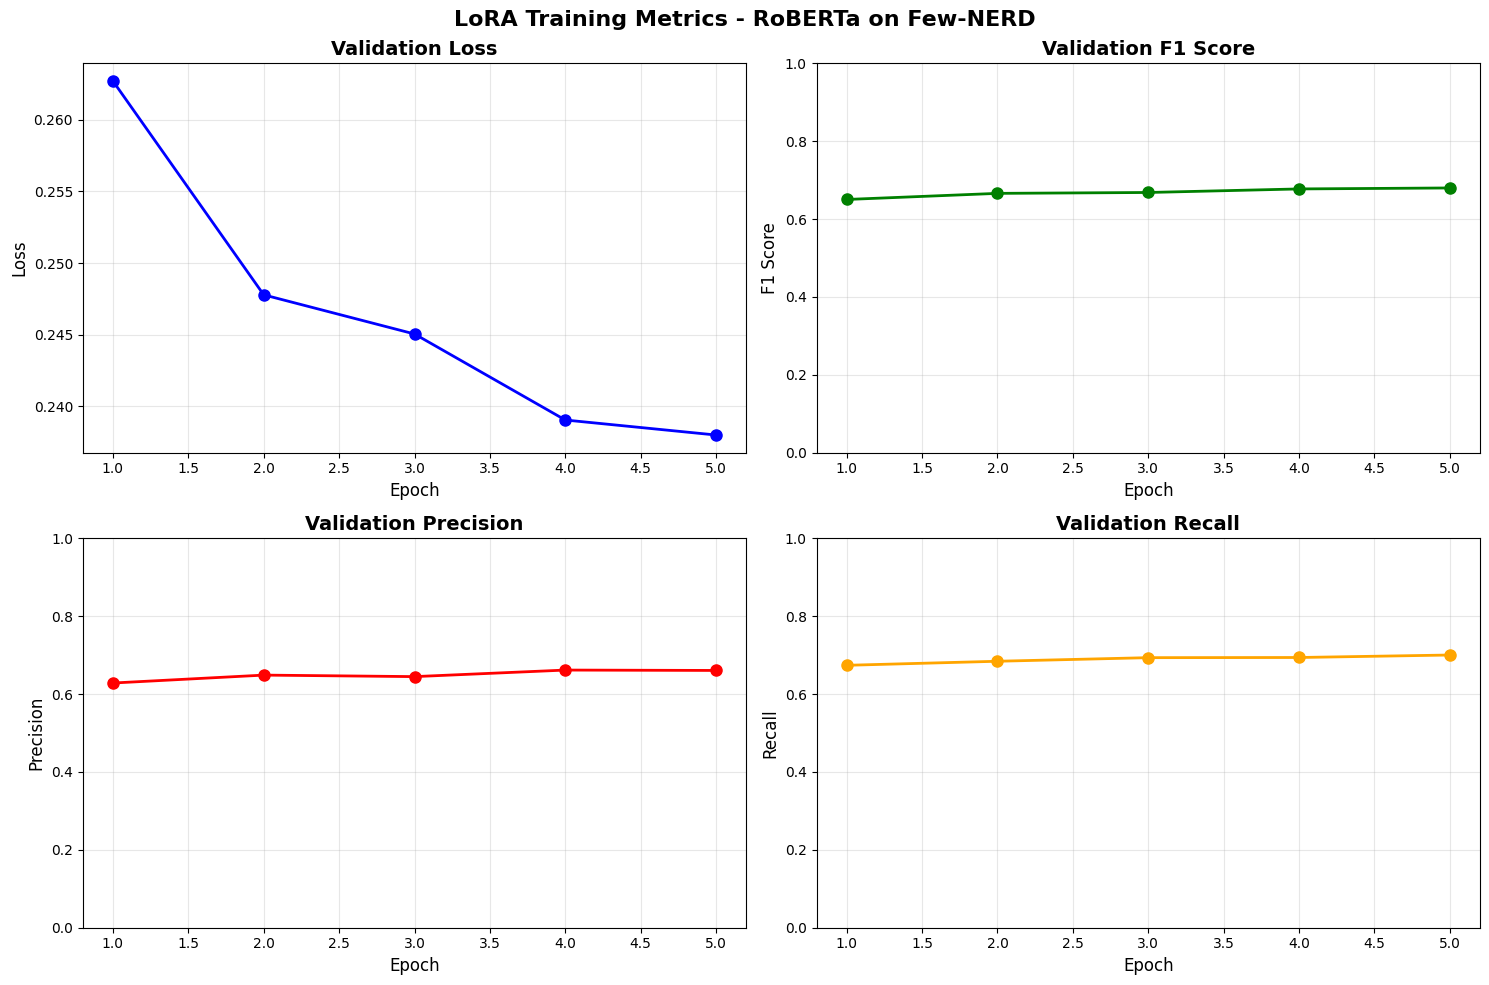

In [ ]:
# ============================================================================
# PLOT TRAINING METRICS
# ============================================================================

print("\n" + "="*80)
print("GENERATING TRAINING PLOTS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('LoRA Training Metrics - RoBERTa on Few-NERD', fontsize=16, fontweight='bold')

# Plot 1: Loss
axes[0, 0].plot(metrics_callback.epochs, metrics_callback.eval_losses, 'b-o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: F1 Score
axes[0, 1].plot(metrics_callback.epochs, metrics_callback.eval_f1s, 'g-o', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('F1 Score', fontsize=12)
axes[0, 1].set_title('Validation F1 Score', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1])

# Plot 3: Precision
axes[1, 0].plot(metrics_callback.epochs, metrics_callback.eval_precisions, 'r-o', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].set_title('Validation Precision', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1])

# Plot 4: Recall
axes[1, 1].plot(metrics_callback.epochs, metrics_callback.eval_recalls, 'orange', marker='o', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Recall', fontsize=12)
axes[1, 1].set_title('Validation Recall', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('lora_training_metrics.png', dpi=300, bbox_inches='tight')
print("✓ Training plots saved as 'lora_training_metrics.png'")
plt.show()

In [ ]:
# Print essential metrics only
print("\n" + "="*80)
print("TRAINING PROGRESS")
print("="*80)
print(f"Best Validation F1: {max(metrics_callback.eval_f1s):.4f} (Epoch {metrics_callback.epochs[metrics_callback.eval_f1s.index(max(metrics_callback.eval_f1s))]:.0f})")
print(f"Final Validation F1: {metrics_callback.eval_f1s[-1]:.4f}")
print(f"Final Validation Loss: {metrics_callback.eval_losses[-1]:.4f}")


TRAINING PROGRESS
Best Validation F1: 0.6799 (Epoch 5)
Final Validation F1: 0.6799
Final Validation Loss: 0.2380


In [ ]:
# ============================================================================
# EVALUATION ON TEST SET
# ============================================================================

print("\n" + "="*80)
print("EVALUATING ON TEST SET")
print("="*80)

test_results = trainer.evaluate(tokenized_test)

print(f"\n{'='*80}")
print("TEST SET RESULTS")
print("="*80)
print(f"Test F1 Score:   {test_results['eval_f1']:.4f}")
print(f"Test Precision:  {test_results['eval_precision']:.4f}")
print(f"Test Recall:     {test_results['eval_recall']:.4f}")
print(f"Test Loss:       {test_results['eval_loss']:.4f}")


EVALUATING ON TEST SET


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: building-other seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: building-hotel seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: location-GPE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: organization-showorganization seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: location-park seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/pyt


TEST SET RESULTS
Test F1 Score:   0.6744
Test Precision:  0.6539
Test Recall:     0.6961
Test Loss:       0.2431


In [ ]:
# ============================================================================
# SAVE LORA ADAPTERS
# ============================================================================

print("\n" + "="*80)
print("SAVING LORA ADAPTERS")
print("="*80)

ADAPTER_PATH = "./roberta-lora-fewnerd-adapters"
model.save_pretrained(ADAPTER_PATH)
tokenizer.save_pretrained(ADAPTER_PATH)


SAVING LORA ADAPTERS


('./roberta-lora-fewnerd-adapters/tokenizer_config.json',
 './roberta-lora-fewnerd-adapters/special_tokens_map.json',
 './roberta-lora-fewnerd-adapters/vocab.json',
 './roberta-lora-fewnerd-adapters/merges.txt',
 './roberta-lora-fewnerd-adapters/added_tokens.json',
 './roberta-lora-fewnerd-adapters/tokenizer.json')

In [ ]:
# Calculate adapter size
import os
def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            total_size += os.path.getsize(filepath)
    return total_size / (1024 * 1024)  # Convert to MB

adapter_size = get_folder_size(ADAPTER_PATH)
print(f"✓ LoRA adapters saved to '{ADAPTER_PATH}'")
print(f"✓ Adapter folder size: {adapter_size:.2f} MB")
print(f"\n📦 DEPLOYMENT READY:")
print(f"   - Use these {adapter_size:.2f} MB adapters for AWS deployment")
print(f"   - Load with: PeftModel.from_pretrained(base_model, '{ADAPTER_PATH}')")
print(f"   - Perfect for AWS Lambda (under 250 MB limit)")


✓ LoRA adapters saved to './roberta-lora-fewnerd-adapters'
✓ Adapter folder size: 7.05 MB

📦 DEPLOYMENT READY:
   - Use these 7.05 MB adapters for AWS deployment
   - Load with: PeftModel.from_pretrained(base_model, './roberta-lora-fewnerd-adapters')
   - Perfect for AWS Lambda (under 250 MB limit)


In [ ]:
# Also save a merged version for easier deployment
print("\n" + "-"*80)
print("SAVING MERGED MODEL (Optional - For Easier Inference)")
print("-"*80)

MERGED_PATH = "./roberta-lora-fewnerd-merged"
merged_model = model.merge_and_unload()
merged_model.save_pretrained(MERGED_PATH)
tokenizer.save_pretrained(MERGED_PATH)

merged_size = get_folder_size(MERGED_PATH)
print(f"✓ Merged model saved to '{MERGED_PATH}'")
print(f"✓ Merged model size: {merged_size:.2f} MB")
print(f"✓ This can be loaded like a standard transformers model")
print(f"\n💡 For AWS deployment: Use adapters ({adapter_size:.2f} MB) to save space!")



--------------------------------------------------------------------------------
SAVING MERGED MODEL (Optional - For Easier Inference)
--------------------------------------------------------------------------------
✓ Merged model saved to './roberta-lora-fewnerd-merged'
✓ Merged model size: 478.05 MB
✓ This can be loaded like a standard transformers model

💡 For AWS deployment: Use adapters (7.05 MB) to save space!


In [ ]:
# ============================================================================
# INFERENCE FUNCTION (OPTIMIZED FOR FASTAPI)
# ============================================================================

class NERPredictor:
    """Production-ready NER predictor for FastAPI deployment"""

    def __init__(self, model_path):
        """
        Initialize predictor with model path

        Args:
            model_path: Path to saved model (merged or adapters)
        """
        self.tokenizer = AutoTokenizer.from_pretrained(model_path, add_prefix_space=True)
        self.model = AutoModelForTokenClassification.from_pretrained(model_path)
        self.model.eval()

        # Move to GPU if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def predict(self, text):
        """
        Predict named entities in text

        Args:
            text: Input text string

        Returns:
            List of dictionaries with entity, label, start, end positions
        """
        # Tokenize
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=512
        ).to(self.device)

        # Get predictions
        with torch.no_grad():
            outputs = self.model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=2)[0].cpu().numpy()

        # Convert tokens to words and align predictions
        tokens = self.tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

        entities = []
        current_entity = None

        for idx, (token, pred_idx) in enumerate(zip(tokens, predictions)):
            if token in [self.tokenizer.cls_token, self.tokenizer.sep_token, self.tokenizer.pad_token]:
                continue

            label = self.model.config.id2label[pred_idx]

            # Handle IO tagging
            if label != 'O':
                # This is an entity token
                if current_entity is None or current_entity["label"] != label:
                    # Start new entity
                    if current_entity:
                        entities.append(current_entity)
                    current_entity = {
                        "entity": token.replace("Ġ", " ").strip(),
                        "label": label,
                        "start": idx,
                        "end": idx
                    }
                else:
                    # Continue current entity
                    current_entity["entity"] += token.replace("Ġ", " ")
                    current_entity["end"] = idx
            else:
                # O tag - no entity
                if current_entity:
                    entities.append(current_entity)
                    current_entity = None

        # Add last entity if exists
        if current_entity:
            entities.append(current_entity)

        return entities

    def predict_batch(self, texts, batch_size=8):
        """
        Batch prediction for multiple texts

        Args:
            texts: List of text strings
            batch_size: Batch size for processing

        Returns:
            List of entity lists
        """
        results = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            batch_results = [self.predict(text) for text in batch]
            results.extend(batch_results)
        return results


In [ ]:
# ============================================================================
# INFERENCE EXAMPLES
# ============================================================================

print("\n" + "="*80)
print("INFERENCE EXAMPLES")
print("="*80)

# Initialize predictor
predictor = NERPredictor(MERGED_PATH)

test_sentences = [
    "Apple Inc. CEO Tim Cook announced the iPhone 15 at the Apple Park campus in Cupertino.",
    "The movie Inception directed by Christopher Nolan won several Academy Awards.",
    "Microsoft headquarters is located in Redmond, Washington near Lake Washington.",
    "Tesla Model S is an electric vehicle manufactured at the Fremont Factory in California.",
    "Elon Musk founded SpaceX and serves as CEO of Tesla Motors in Palo Alto.",
    "Arjun studies at SITS Pune and works on machine learning projects."
]

for i, text in enumerate(test_sentences, 1):
    print(f"\n{'-'*80}")
    print(f"Example {i}:")
    print(f"Text: {text}")
    print("\nDetected Entities:")

    entities = predictor.predict(text)
    if entities:
        for ent in entities:
            print(f"  • {ent['entity']:<45} [{ent['label']}]")
    else:
        print("  (No entities detected)")


INFERENCE EXAMPLES

--------------------------------------------------------------------------------
Example 1:
Text: Apple Inc. CEO Tim Cook announced the iPhone 15 at the Apple Park campus in Cupertino.

Detected Entities:
  • Apple Inc.                                    [organization-company]
  • Tim Cook                                      [person-other]
  • iPhone 15                                     [product-other]
  • Apple Park                                    [location-park]
  • Cupertino                                     [location-GPE]

--------------------------------------------------------------------------------
Example 2:
Text: The movie Inception directed by Christopher Nolan won several Academy Awards.

Detected Entities:
  • Inception                                     [art-film]
  • Christopher Nolan                             [person-director]
  • Academy Awards                                [other-award]

------------------------------------------------

In [ ]:
!zip -r roberta-lora-fewnerd-merged.zip /content/roberta-lora-fewnerd-merged

  adding: content/roberta-lora-fewnerd-merged/ (stored 0%)
  adding: content/roberta-lora-fewnerd-merged/vocab.json (deflated 59%)
  adding: content/roberta-lora-fewnerd-merged/merges.txt (deflated 53%)
  adding: content/roberta-lora-fewnerd-merged/tokenizer_config.json (deflated 75%)
  adding: content/roberta-lora-fewnerd-merged/model.safetensors (deflated 37%)
  adding: content/roberta-lora-fewnerd-merged/special_tokens_map.json (deflated 52%)
  adding: content/roberta-lora-fewnerd-merged/config.json (deflated 70%)
  adding: content/roberta-lora-fewnerd-merged/tokenizer.json (deflated 82%)
